# 2019 AAPOR Text Analytics Tutorial
### Patrick van Kessel
#### Senior Data Scientist, Pew Research Center

These materials are adapted from workshops I did in 2018 and 2019 for NYAAPOR, the World Bank, and IBM, with a lot of help from an old colleague of mine, Michael Jugovich (now at IBM). You can access a GitHub repository containing this notebook and the data sample here: https://github.com/patrickvankessel/AAPOR-Text-Analysis-2019 

## Loading in the data

We'll use a sample from the Kaggle Amazon Fine Food Reviews dataset. The full dataset can be found here: https://www.kaggle.com/snap/amazon-fine-food-reviews 

In [0]:
import pandas as pd

In [0]:
sample = pd.read_csv("https://raw.githubusercontent.com/patrickvankessel/AAPOR-Text-Analysis-2019/master/kaggle_sample.csv")

In [3]:
print(len(sample))

10000


Let's see what's in here.

In [4]:
sample.head()

,Unnamed: 0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,0,467510,467511,B003WECB5S,A2G0LDLGXKQFYP,behrlekidsmom,2,2,3,1304640000,Holes in wrappers,The kids said the taste/flavor is fine but A L...
1,1,291775,291776,B000FVYUFA,A34O5D0QRGV29N,a Dallas reader,1,1,5,1188432000,Absolutely the best!,How can something this good be good for you to...
2,2,180629,180630,B000CQBZQK,A3ER3V2E06DH7D,"A. K. Kaw ""AKK""",0,1,5,1247529600,Tea meant for a late evening,"I love Earl Grey Tea. I have tried Tazo, Twini..."
3,3,412055,412056,B000CQC05K,A39Y02EJ310WJR,"Tech Girl ""Wendy""",2,2,5,1236729600,"Full-flavored, delicious tea that you can drin...",This tea is so fruity and full-flavored that i...
4,4,139779,139780,B001BCXTGS,A1LC1NMRA1ZEDZ,M. Garcia,1,1,5,1244332800,My cat only eats this brand,My cat is not crazy about the snapper and shri...


### Examine the data

Run the cell below a few times, let's take a look at our text and see what it looks like.  Always take a look at your raw data.

In [5]:
sample.sample(10)['Text'].values

array(['Not that I\'ve tasted this stuff, mind you, but according to my fussy Persian, he thinks it hung the moon!  The grilled and roasted varieties provide some sort of "extra" punch of flavor for him so, well, must be a guy thing because my female won\'t touch any of it.  Weird, I know, but I think it goes back to that tailgating thing guys do with the brats and other "guy stuff."  My male is all over the beef and grilled varieties but my female, she prefers the pates.  Overall, the quality of this food is awesome, better than Iams and worth the price.  It\'s about $6 higher here than what I pay for it but I\'m in Ohio, the armpit capital of the world so things are cheaper here so they can get us to stay..... Highly recommend!',
       "I had never tried blackstrap molasses before and I was expecting not to like the taste after reading many online comments about how awful it tastes and how much it's an acquired taste.  I bought this from the grocery store since it was on sale, and I

### Preprocess the text (clean it up!)

I don't know about you, but I noticed some junk in our data - HTML and URLs.  Let's clear that out first.  We'll also take this opportunity to lemmatize the words - to do that, we'll install NLTK's WordNet library.

In [6]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
import re
from nltk.stem import WordNetLemmatizer

# Initialize a lemmatizer
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # First we'll use regular expressions to strip out links and HTML tags
    text = re.sub(r'http[a-zA-Z0-9\&\?\=\?\/\:\.]+\b', ' ', text)
    text = re.sub(r'\<[^\<\>]+\>', ' ', text)
    # Next, let's clear out all punctuation and replace it with whitespace
    text = re.sub(r'\W+', ' ', text) 
    # And clear out numbers
    text = re.sub(r'[0-9]+', ' ', text)
    # And then lowercase
    text = text.lower()
    # This isn't going to be perfect - ideally we expand contractions first
    # And also deal with spelling corrections
    # But this will work well enough for now
    
    # Next, let's split on whitespace and then lemmatize each token
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(x) for x in tokens]
    text = " ".join(tokens)
  
    return text

sample['Text'] = sample['Text'].map(clean_text)

Let's see what our data look like now that we've processed the text

In [8]:
sample.sample(10)['Text'].values

array(['i bought the whirley pop stovetop popcorn popper several month ago which of course the wabash valley popcorn came recommended same company i thought what the heck i ve always wondered how gourmet popcorn differed from orville or other everyday popcorn brand let me tell you it is worth the extra money i can really taste the difference in quality and normal popcorn just doesn t taste right when you make it in the whirley pop this popcorn is so tender and tasty it wa a little weird to see and eat at first because it s about half the size of regular popcorn but i believe this characteristic is essential in helping the seasoning completely coat the corn my favorite prep method include using the whirley pop and nutiva organic extra virgin coconut oil see my review for that for more detail i add a little peanut oil sea salt black pepper and a good amount of vegaline garlic mist cooking seasoning spray yummy i ve tried the other amish country popcorn and they re all good this is my fav

## TF-IDF Vectorization (Feature Extraction)

Just to be safe, let's add some additional words to a standard list of English stop words.

In [0]:
from sklearn.feature_extraction import stop_words as sklearn_stop_words
# Grab standard English stopwords
stop_words = set(sklearn_stop_words.ENGLISH_STOP_WORDS)
# And add in some of our own ("like" is really common and doesn't tell us much)
stop_words = stop_words.union(set([
    "www", "http", "https", "br", "amazon", "href", "wa", "ha",
    "like", "just",
]))

Okay, now let's tokenize our text and turn it into numbers

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

tfidf_vectorizer = TfidfVectorizer(
    max_df=0.9, # Remove any words that appear in more than 90% of our documents
    min_df=5, # Remove words that appear in fewer than 5 document
    ngram_range=(1, 1), # Only extract unigrams
    stop_words=stop_words, # Remove stopwords
    max_features=2500 # Grab the 2500 most common words (based on above constraints)
)
tfidf = tfidf_vectorizer.fit_transform(sample['Text'])
ngrams = tfidf_vectorizer.get_feature_names()

In [11]:
tfidf

<10000x2500 sparse matrix of type '<class 'numpy.float64'>'
	with 245835 stored elements in Compressed Sparse Row format>

Because words are really big, by default we work with sparse matrices.  We can expand the sparse matrix with `.todense()` and compute sums like a normal dataframe.  Let's check out the top 20 words.

In [12]:
ngram_df = pd.DataFrame(tfidf.todense(), columns=ngrams) 
ngram_df.sum().sort_values(ascending=False)[:20]

coffee     316.980063
good       308.366277
taste      306.032427
great      296.119454
tea        286.896549
love       283.353920
product    281.596502
flavor     278.327891
food       213.044387
dog        205.873217
really     178.868613
price      175.593576
time       165.726609
make       165.491621
cup        165.306249
buy        163.445115
best       162.054263
bag        154.881833
ve         151.040409
don        145.061858
dtype: float64

We can also explore word co-occurrences - the words that most frequently appear together in the same documents

In [13]:
count_vectorizer = CountVectorizer(
    max_df=.9, 
    min_df=50, 
    stop_words=stop_words
)
counts = count_vectorizer.fit_transform(sample['Text'])
ngrams = count_vectorizer.get_feature_names()
cooccurs = (counts.T * counts) 
cooccurs.setdiag(0)
cooccurs = pd.DataFrame(cooccurs.todense(), index=ngrams, columns=ngrams)
cooccurs.head()

,able,absolutely,acid,actual,actually,add,added,addicted,adding,addition,admit,adult,afternoon,aftertaste,age,ago,agree,air,allergic,allergy,almond,alot,alternative,amazing,american,animal,anymore,apple,appreciate,area,aren,aroma,arrived,artificial,ask,asked,ate,available,average,avoid,...,wasn,waste,watch,water,way,weak,website,week,weight,weird,wellness,went,wet,wheat,white,wife,wine,winter,wish,won,wonder,wonderful,word,work,worked,working,world,worry,worse,worst,worth,wouldn,wow,wrapped,wrong,year,yes,yogurt,yum,yummy
able,0,12,4,3,34,25,18,1,12,0,12,5,1,4,6,14,6,2,1,11,2,4,7,9,7,4,8,5,6,7,9,5,18,9,3,2,4,19,1,5,...,24,3,6,74,62,5,11,26,10,4,3,18,9,16,16,11,1,5,12,26,3,17,5,44,5,3,18,5,2,3,22,15,2,5,5,65,16,5,4,2
absolutely,12,0,9,6,26,21,14,2,4,6,5,6,1,4,2,8,4,3,3,7,18,3,8,15,1,2,5,13,2,3,6,4,9,5,0,1,3,6,3,4,...,5,3,1,29,30,0,8,13,11,4,15,15,4,6,5,6,0,4,6,13,0,22,6,24,3,5,1,3,4,4,20,9,4,3,5,29,13,5,1,6
acid,4,9,0,1,28,23,10,2,3,2,6,12,1,6,0,9,3,0,0,2,2,3,12,4,4,15,5,6,2,2,3,23,0,10,7,3,2,13,16,6,...,8,0,1,87,28,8,8,25,13,0,12,8,1,19,18,0,6,0,14,5,0,11,2,13,3,4,6,10,7,3,22,7,4,0,1,24,12,7,2,2
actual,3,6,1,0,16,11,9,0,3,4,2,0,1,2,0,5,0,3,0,1,2,0,2,1,2,0,1,2,1,0,3,1,5,9,1,1,2,6,4,2,...,5,0,1,22,23,1,5,6,5,0,4,3,1,5,6,2,3,0,2,3,0,4,1,14,1,0,0,1,5,0,1,8,1,6,1,9,1,3,1,1
actually,34,26,28,16,0,53,50,4,23,7,9,4,4,12,4,14,10,9,6,13,45,1,19,18,4,5,12,24,8,10,15,12,23,29,6,6,12,22,10,12,...,36,12,1,127,66,9,10,40,26,10,17,36,17,17,19,8,17,6,11,32,11,18,7,64,11,15,15,4,10,7,32,32,9,11,15,67,23,12,0,17


In [0]:
rows, scanned = [], []
for word1, row in cooccurs.iterrows():
  for word2 in row.keys():
    if word2 not in scanned and row[word2] >= 100:
      rows.append({
          "pair": (word1, word2), "count": row[word2]
      })
  scanned.append(word1)


In [15]:
sorted(rows, key=lambda x: x["count"], reverse=True)[:25]

[{'count': 3307, 'pair': ('cat', 'food')},
 {'count': 3236, 'pair': ('coffee', 'cup')},
 {'count': 3093, 'pair': ('dog', 'food')},
 {'count': 2321, 'pair': ('good', 'taste')},
 {'count': 2256, 'pair': ('coffee', 'taste')},
 {'count': 2103, 'pair': ('flavor', 'taste')},
 {'count': 2094, 'pair': ('coffee', 'flavor')},
 {'count': 2031, 'pair': ('dog', 'treat')},
 {'count': 1984, 'pair': ('taste', 'tea')},
 {'count': 1962, 'pair': ('coffee', 'good')},
 {'count': 1859, 'pair': ('flavor', 'good')},
 {'count': 1659, 'pair': ('eat', 'food')},
 {'count': 1619, 'pair': ('flavor', 'tea')},
 {'count': 1592, 'pair': ('food', 'product')},
 {'count': 1580, 'pair': ('product', 'taste')},
 {'count': 1553, 'pair': ('coffee', 'pod')},
 {'count': 1553, 'pair': ('green', 'tea')},
 {'count': 1524, 'pair': ('bag', 'tea')},
 {'count': 1519, 'pair': ('good', 'tea')},
 {'count': 1457, 'pair': ('good', 'product')},
 {'count': 1437, 'pair': ('great', 'taste')},
 {'count': 1360, 'pair': ('food', 'good')},
 {'count

## Classification

Let's go back to the TF-IDF matrix and use it to do some classification

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

tfidf_vectorizer = TfidfVectorizer(
    max_df=0.9, # Remove any words that appear in more than 90% of our documents
    min_df=5, # Remove words that appear in fewer than 5 document
    ngram_range=(1, 1), # Only extract unigrams
    stop_words=stop_words, # Remove stopwords
    max_features=2500 # Grab the 2500 most common words (based on above constraints)
)
tfidf = tfidf_vectorizer.fit_transform(sample['Text'])
ngrams = tfidf_vectorizer.get_feature_names()

Let's make an outcome variable.  How about we try to predict 5-star reviews, and then maybe helpfulness?

In [0]:
sample['good_score'] = sample['Score'].map(lambda x: 1 if x == 5 else 0)
sample['was_helpful'] = ((sample['HelpfulnessNumerator'] / sample['HelpfulnessDenominator']).fillna(0.0) > .80).astype(int)

In [0]:
column_to_predict = 'good_score'

In [0]:
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn import metrics

results = []
kfolds = StratifiedKFold(n_splits=5)

We just created an object that'll split the data into fifths, and then iterate over it five times, holding out one-fifth each time for testing.  Let's do that now.  Each "fold" contains an index for training rows, and one for testing rows.  For each fold, we'll train a basic linear Support Vector Machine, and evaluate its performance.

In [20]:
for i, fold in enumerate(kfolds.split(tfidf, sample[column_to_predict])):
    
    train, test = fold 
    print("Running new fold, {} training cases, {} testing cases".format(len(train), len(test)))
    
    clf = svm.LinearSVC(
        max_iter=1000,
        penalty='l2',
        class_weight='balanced',
        loss='squared_hinge'
    )
    # We picked some decent starting parameters, but you can try out different ones
    # http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html 
    # If you're ambitious - check out the Scikit-Learn documentation and test out different models
    # http://scikit-learn.org/stable/supervised_learning.html
    # XGBoost is one of my favorites, and there's an Scikit-Learn wrapper for it
    # https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/
    
    training_text = tfidf[train]
    training_outcomes = sample[column_to_predict].loc[train]
    clf.fit(training_text, training_outcomes) # Train the classifier on the training data
    
    test_text = tfidf[test]
    test_outcomes = sample[column_to_predict].loc[test]
    predictions = clf.predict(test_text) # Get predictions for the test data
    
    precision, recall, fscore, support = metrics.precision_recall_fscore_support(
        test_outcomes, # Compare the predictions against the true outcomes
        predictions
    )
    
    results.append({
        "fold": i,
        "outcome": 0,
        "precision": precision[0],
        "recall": recall[0],
        "fscore": fscore[0],
        "support": support[0]
    })
    
    results.append({
        "fold": i,
        "outcome": 1,
        "precision": precision[1],
        "recall": recall[1],
        "fscore": fscore[1],
        "support": support[1]
    })
    
results = pd.DataFrame(results)

Running new fold, 8000 training cases, 2000 testing cases
Running new fold, 8000 training cases, 2000 testing cases
Running new fold, 8000 training cases, 2000 testing cases
Running new fold, 8000 training cases, 2000 testing cases
Running new fold, 8000 training cases, 2000 testing cases


How'd we do?

In [21]:
print(results.groupby("outcome").mean()[['precision', 'recall']])
print(results.groupby("outcome").std()[['precision', 'recall']])

         precision    recall
outcome                     
0         0.641014  0.698769
1         0.817090  0.774626
         precision    recall
outcome                     
0         0.008326  0.020460
1         0.009987  0.005897


Now we know that our model is pretty stable and reasonably performant, we can fit and transform the full dataset.

In [22]:
clf.fit(tfidf, sample[column_to_predict])  
print(metrics.classification_report(sample[column_to_predict].loc[test], predictions))
print(metrics.confusion_matrix(sample[column_to_predict].loc[test], predictions))

              precision    recall  f1-score   support

           0       0.64      0.72      0.68       731
           1       0.83      0.77      0.80      1269

    accuracy                           0.75      2000
   macro avg       0.74      0.75      0.74      2000
weighted avg       0.76      0.75      0.75      2000

[[528 203]
 [293 976]]


And now we can see what the most predictive features are.

In [23]:
import numpy as np

ngram_coefs = sorted(zip(ngrams, clf.coef_[0]), key=lambda x: x[1], reverse=True)
ngram_coefs[:10]

[('highly', 3.1013089738143287),
 ('best', 2.444740644553053),
 ('love', 2.306617070446386),
 ('perfect', 2.2929056338458307),
 ('favorite', 2.1200027087198525),
 ('wonderful', 2.006322948279272),
 ('cancer', 1.9431169727387974),
 ('fabulous', 1.8950394468562675),
 ('satisfied', 1.8690450683854933),
 ('addicted', 1.8094483299768616)]

What happens if you change the outcome column to "was_helpful" and re-run it again?  Can you think of ways to improve this?  Add more stopwords?  Include bigrams in addition to unigrams?

## Topic Modeling

In [0]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [0]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #{}: {}".format(
            topic_idx,
            ", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        ))

Let's find some topics.  We'll check out non-negative matrix factorization (NMF) first.

In [26]:
nmf = NMF(n_components=10, random_state=42, alpha=.1, l1_ratio=.5).fit(tfidf)
# Try out different numbers of topics (change n_components)
# Documentation: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
print("\nTopics in NMF model:")
print_top_words(nmf, ngrams, 10)


Topics in NMF model:
Topic #0: flavor, taste, sugar, ve, really, make, water, tried, don, little
Topic #1: coffee, cup, strong, roast, bold, flavor, blend, keurig, dark, pod
Topic #2: tea, green, bag, drink, cup, iced, stash, black, taste, earl
Topic #3: dog, treat, love, food, chew, bone, small, size, teeth, toy
Topic #4: cat, food, eat, dry, wellness, canned, chicken, ingredient, love, vet
Topic #5: product, store, price, order, buy, local, grocery, shipping, time, box
Topic #6: great, love, snack, price, deal, taste, healthy, recommend, highly, tasting
Topic #7: chocolate, bar, dark, snack, nut, peanut, candy, protein, sweet, calorie
Topic #8: chip, bag, salt, potato, kettle, snack, vinegar, salty, flavor, fat
Topic #9: good, really, price, taste, pretty, quality, tasting, quite, fresh, enjoy


LDA is an other popular topic modeling technique

In [27]:
lda = LatentDirichletAllocation(n_components=10, random_state=42).fit(tfidf)
# Documentation: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
# doc_topic_prior (alpha) - lower alpha means documents will be composed of fewer topics (higher means a more uniform distriution across all topics)
# topic_word_prior (beta) - lower beta means topics will be composed of fewer words (higher means a more uniform distribution across all words)
print("\nTopics in LDA model:")
print_top_words(lda, ngrams, 10)


Topics in LDA model:
Topic #0: coffee, cup, flavor, taste, drink, good, strong, great, roast, tea
Topic #1: taste, bar, sugar, good, great, flavor, chocolate, product, snack, calorie
Topic #2: sauce, chip, salt, great, pasta, flavor, soup, good, cheese, spicy
Topic #3: chocolate, great, love, good, cereal, snack, box, cider, curry, bag
Topic #4: tea, popcorn, taste, flavor, good, bag, drink, green, chai, great
Topic #5: dog, treat, love, chew, teeth, toy, bone, size, training, great
Topic #6: product, price, arrived, gift, order, great, store, good, item, box
Topic #7: sleep, product, night, help, container, calm, great, link, good, jack
Topic #8: food, cat, dog, product, love, eat, good, year, bag, time
Topic #9: store, baby, love, product, great, price, time, buy, year, good


We can use the topic models the same way we did our classifier - everything in Scikit-Learn follows the same fit/transform paradigm.  So, let's get the topics for our documents.

In [0]:
doc_topics = pd.DataFrame(lda.transform(tfidf))

In [29]:
doc_topics.head()

,0,1,2,3,4,5,6,7,8,9
0,0.024099,0.024098,0.783103,0.024103,0.024096,0.024099,0.024098,0.024106,0.024102,0.024097
1,0.750107,0.027767,0.027766,0.027764,0.027766,0.027765,0.027768,0.027763,0.027767,0.027766
2,0.016939,0.016949,0.016949,0.016937,0.815528,0.016946,0.016941,0.016941,0.016946,0.048924
3,0.023150,0.023149,0.023147,0.023146,0.791670,0.023147,0.023147,0.023151,0.023146,0.023147
4,0.021649,0.021662,0.021655,0.021648,0.021648,0.021651,0.021647,0.021650,0.805141,0.021650


In [0]:
topic_column_names = ["topic_{}".format(c) for c in doc_topics.columns]
doc_topics.columns = topic_column_names

Next we use Pandas to join the topics with the original sample dataframe

In [0]:
sample_with_topics = pd.concat([sample, doc_topics], axis=1)

Let's look for patterns by running some means and correlations

In [32]:
topic_columns = [col for col in sample_with_topics.columns if col.startswith("topic_")]
sample_with_topics.groupby("good_score").mean()[topic_columns]

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
good_score,,,,,,,,,,
0,0.183903,0.226292,0.065056,0.041901,0.076930,0.058601,0.071276,0.033828,0.172662,0.069551
1,0.142316,0.226311,0.087173,0.047796,0.090577,0.068197,0.092969,0.034686,0.127523,0.082451


In [33]:
for topic in topic_column_names:
    print("{}: {}".format(topic, sample_with_topics[topic].corr(sample_with_topics['Score'])))

topic_0: -0.025292235465098012
topic_1: 0.012046757693743665
topic_2: 0.06959235818628244
topic_3: 0.023446401876468924
topic_4: 0.03599689524129321
topic_5: 0.03409134227342527
topic_6: 0.04691101261547623
topic_7: -0.001684816652652065
topic_8: -0.13859039591384575
topic_9: 0.019007709950536102


Here's an example of a linear regression

In [34]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

training_data = sample_with_topics[topic_column_names[:-1]] 
# We're leaving a column out to avoid multicollinearity

regression = linear_model.LinearRegression()

# Train the model using the training sets
regression.fit(training_data, sample_with_topics['Score'])
coefficients = regression.coef_
for topic, coef in zip(topic_column_names[:-1], coefficients):
  print("{}: {}".format(topic, coef))

topic_0: -0.21269382796846162
topic_1: -0.0843114794912539
topic_2: 0.3907048768291855
topic_3: 0.10179168229468046
topic_4: 0.10070443473499552
topic_5: 0.1935251748886604
topic_6: 0.1836870262014428
topic_7: -0.21131708369325589
topic_8: -0.7277794219956407


Sadly Scikit-Learn doesn't make it easy to get p-values or a regression report like you'd normally expect of something like R or Stata.  Scikit-Learn is more about prediction than statistical analysis; for the latter, we can use Statsmodels.  

In [35]:
import statsmodels.api as sm

regression = sm.OLS(sample_with_topics['Score'], training_data)
results = regression.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Score   R-squared (uncentered):                   0.880
Model:                            OLS   Adj. R-squared (uncentered):              0.879
Method:                 Least Squares   F-statistic:                              8108.
Date:                Mon, 09 Dec 2019   Prob (F-statistic):                        0.00
Time:                        16:55:21   Log-Likelihood:                         -18356.
No. Observations:               10000   AIC:                                  3.673e+04
Df Residuals:                    9991   BIC:                                  3.680e+04
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### K-Means Clustering

We can also check out other unsupervised methods like clustering.  I borrowed/modified some of this code from http://brandonrose.org/clustering

In [0]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, max_iter=50, tol=.01, n_jobs=-1)
# http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
kmeans.fit(tfidf)
clusters = kmeans.labels_.tolist() # You can merge these back into the data if you want

In [37]:
centroids = kmeans.cluster_centers_.argsort()[:, ::-1] 
for i, closest_ngrams in enumerate(centroids):
    print("Cluster #{}: {}".format(i, ", ".join(np.array(ngrams)[closest_ngrams[:8]])))

Cluster #0: chip, potato, bag, flavor, kettle, snack, great, salt
Cluster #1: dog, treat, food, love, chew, product, good, bone
Cluster #2: tea, taste, green, bag, drink, flavor, good, cup
Cluster #3: coffee, cup, flavor, strong, good, taste, roast, bold
Cluster #4: chocolate, dark, cooky, taste, hot, good, flavor, milk
Cluster #5: cat, food, eat, love, treat, wellness, chicken, dry
Cluster #6: product, great, price, good, store, love, taste, time
Cluster #7: bar, chocolate, snack, taste, nut, protein, good, sweet
Cluster #8: great, love, good, flavor, price, buy, time, store
Cluster #9: taste, good, sugar, great, flavor, drink, water, free


### Agglomerative/Hierarchical Clustering

Instead of specifying the number of clusters upfront, now we're going to use hierarchical clustering to characterize how similar words are to each other, again based on their co-occurrence within documents. To keep things manageable, we'll use a smaller set of 500 words.

In [0]:
# This Python library lets us produce graphics
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.25, # Focus on less common, more unique words
    min_df=5, 
    ngram_range=(1, 1), 
    stop_words=stop_words, 
    max_features=200 # <- smaller set of words
)
tfidf = tfidf_vectorizer.fit_transform(sample['Text'])
ngrams = tfidf_vectorizer.get_feature_names()

In [0]:
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics.pairwise import cosine_similarity

# We'll use cosine similarity to get word similarities based on document overlap
# This produces a matrix of every word compared to every other word
# With a value of 0 - 1, indicating how often they occur together in the same documents
# To get document similarities in terms of word overlap, just drop the .transpose()!
similarities = cosine_similarity(tfidf.transpose()) 
distances = 1 - similarities # Converts to distances
clusters = linkage(distances, method='ward') # Run hierarchical clustering on the distances

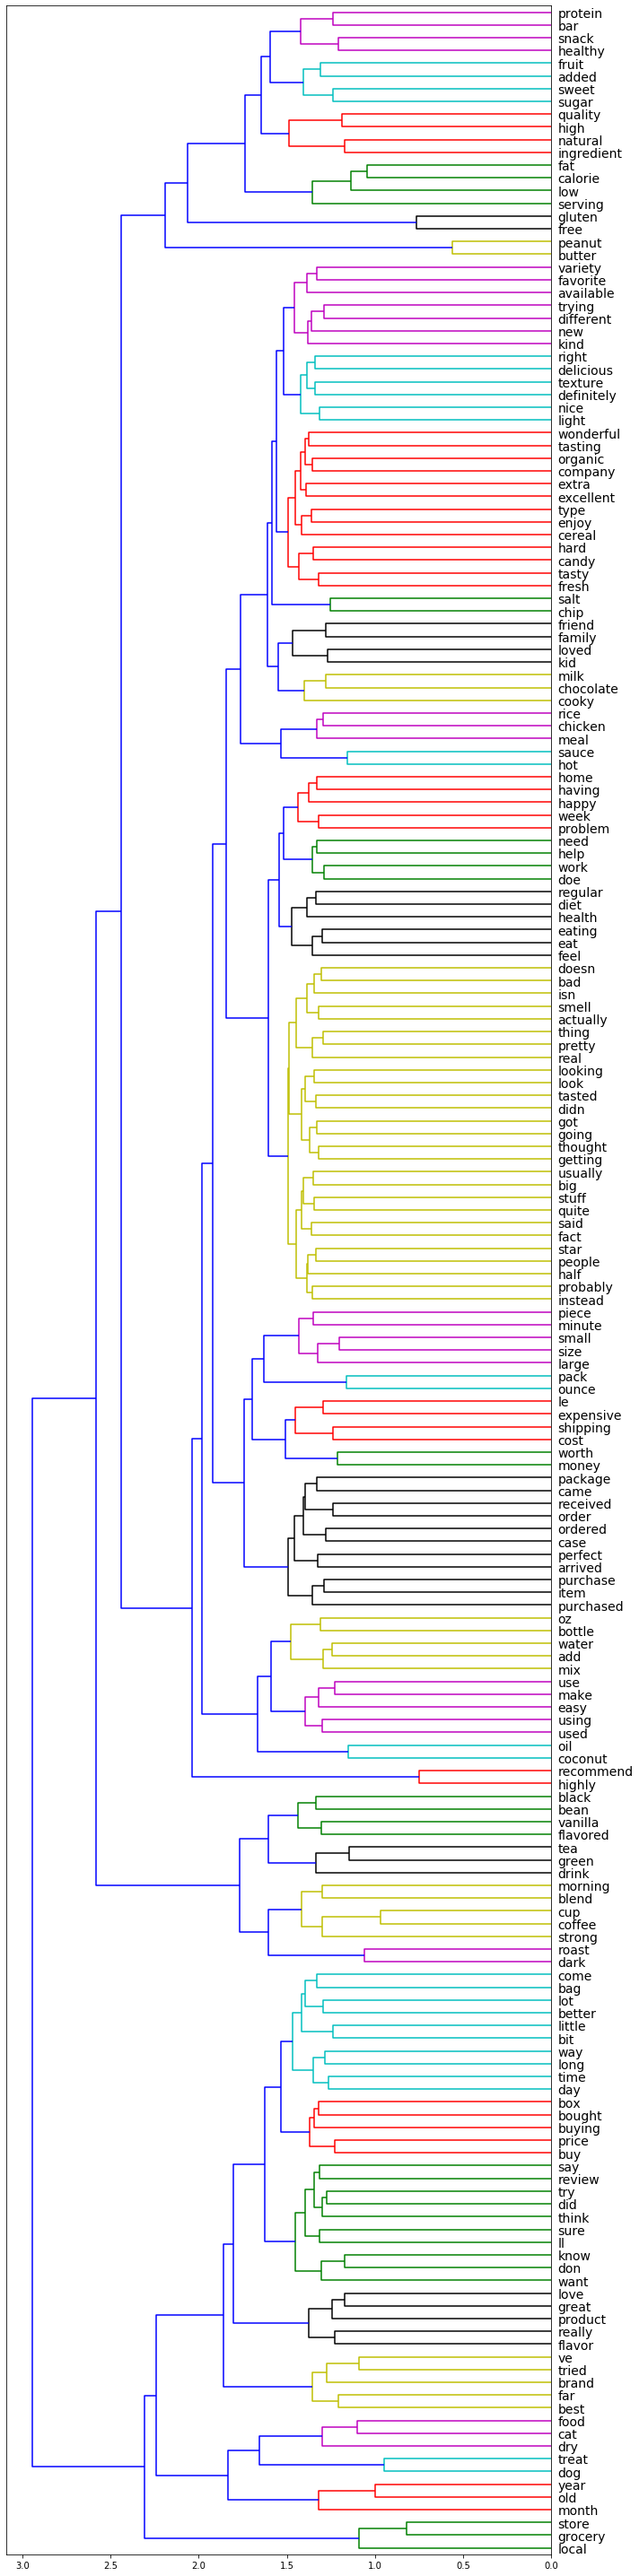

In [41]:
fig, ax = plt.subplots(figsize=(10, 40))
ax = dendrogram(
    clusters, 
    labels=ngrams, 
    orientation="left", 
    leaf_font_size=14, 
    color_threshold=1.5
)
plt.tight_layout()